IndexError: list index out of range

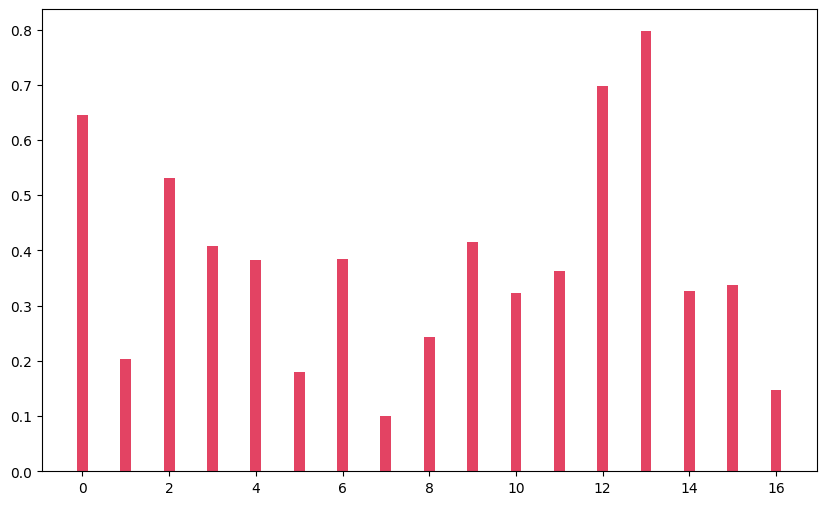

: 

In [8]:
# plot the average latency for tpch from "NDP_test/data_collection/tpch_latency.txt"

import matplotlib.pyplot as plt

# 从文件中加载数据
def load_data(file_path):
    data = {"ceph_tpch": {}, "skyhook": {}, "non_skyhook": {}}
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split(", ")
            category = parts[0].split(": ")[1]
            query_no = int(parts[1].split(": ")[1])
            latency = float(parts[3].split(": ")[1])
            if query_no not in data[category]:
                data[category][query_no] = []
            data[category][query_no].append(latency)
    return data

# 计算每个查询类别的平均延迟
def calculate_average_latency(data):
    average_latency = {"ceph_tpch": [], "skyhook": [], "non_skyhook": []}
    for category, values in data.items():
        for query_no, latencies in values.items():
            average_latency[category].append(sum(latencies) / len(latencies))
    return average_latency

def plot_bar_chart(data):
    average_latency = calculate_average_latency(data)
    categories = list(average_latency.keys())
    
    # 需要从数据中提取所有独特的query_no，并按顺序排列
    query_nos = sorted(list(set([query_no for category in data.values() for query_no in category.keys()])))

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.25
    opacity = 0.8

    colors = ['crimson', 'darkcyan', 'turquoise']

    # 根据query_nos的数量来调整index的生成方式
    for i, category in enumerate(categories):
        # 对于每个query_no，计算它的位置
        x = [x + i * bar_width for x in range(len(query_nos))]
        # 选择当前类别的平均延迟
        latencies = [average_latency[category][j] for j in range(len(query_nos))]
        ax.bar(x, latencies, bar_width, alpha=opacity, color=colors[i],label=category)

    ax.set_xlabel('Query Number')
    ax.set_ylabel('Average Latency')
    ax.set_title('Average Latency by Query Number and Category')
    # 设置xticks位置和标签为所有独特的query_no
    ax.set_xticks([x + (len(categories) - 1) * bar_width / 2 for x in range(len(query_nos))])
    ax.set_xticklabels(query_nos)
    ax.legend()

    plt.tight_layout()
    plt.show()

# 加载数据
file_path = "/home/yue21/mlndp/NDP_test/data_collection/tpch_latency.txt"
data = load_data(file_path)

# 绘制柱状图
plot_bar_chart(data)

   


In [2]:
#generate k_means dataset

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# Generate sample data
n_samples = 50000000
# n_samples = 5000000

dir_name = '/mnt/cephfs/k_means/kmeans_data.parquet'
# dir_name = '/mnt/cephfs/k_means_light/kmeans_data.parquet'


random_state =100 #42
n_features = 2
n_centers = 3  # Assuming we want 4 clusters

X, _ = make_blobs(n_samples=n_samples, centers=n_centers, n_features=n_features, random_state=random_state)

# Convert to DataFrame
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])

# Save to Parquet
table = pa.Table.from_pandas(df)
pq.write_table(table, dir_name)

In [3]:
# execute the k_means

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import time


rounds = 100
n_clusters = 3
category = 'skyhook'
# category == "non_skyhook"
# category = "pure_k_means"


if category == 'skyhook':
    format_ = ds.SkyhookFileFormat("parquet", "/etc/ceph/ceph.conf")
elif category == "non_skyhook":
    format_ = ds.SkyhookFileFormat("parquet")

if category == 'skyhook' or category == "non_skyhook":
    dataset = ds.dataset('/mnt/cephfs/k_means',format = format_)
    table = dataset.to_table()
    df = table.to_pandas()

    # Extract features from the DataFrame
    features = df[['Feature_1', 'Feature_2']]

    # Execute KMeans clustering on the data
    n_clusters = 3
    for i in range(rounds):
        s = time.time()
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        df['Cluster'] = kmeans.fit_predict(features)
        # df['Cluster'] = kmeans.predict(features)
        e = time.time()

        print(f"category: {category}, k_means_latency: {e - s}")
        with open('NDP_test/data_collection/k_means_latency.txt', 'a') as file:
            file.write(f"category: {category}, round: {i}, latency: {e - s}\n")

KeyboardInterrupt: 

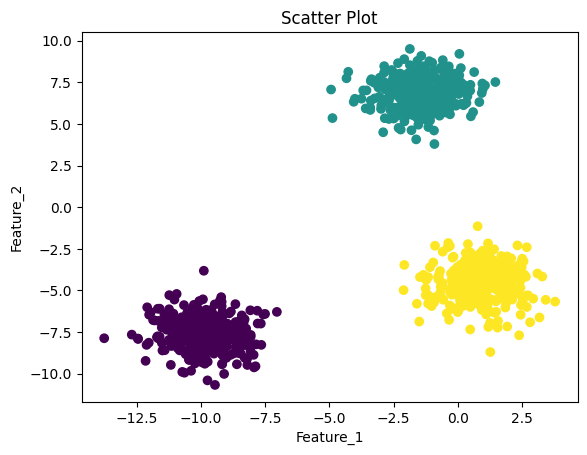

In [7]:
import pandas as pd
# import pyodbc
from sklearn.cluster import KMeans as km
import matplotlib.pyplot as plt
import duckdb
import pyarrow.dataset as ds

format_ = ds.SkyhookFileFormat("parquet")
# format_ = ds.SkyhookFileFormat("parquet", "/etc/ceph/ceph.conf")
dataset = ds.dataset('/mnt/cephfs/k_means',format = format_)

query = 'SELECT Feature_1, Feature_2 FROM dataset LIMIT 1000'


conn = duckdb.connect()
# df = pd.read_sql(query, conn)
df = conn.execute(query).fetchdf()

features = df[['Feature_1', 'Feature_2']]

kmeans = km(n_clusters=3, random_state=42,n_init=10)
kmeans.fit(features)

plt.scatter(df['Feature_1'], df['Feature_2'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.title('Scatter Plot')
plt.show()
# Close your SQL Server database connection
conn.close()



In [ ]:
#delete monitor_cpu.csv

import os

# List of file paths you want to delete
files_to_delete = [
    "/home/yue21/mlndp/NDP_test/data_collection/worker4_monitor_cpu.csv",
    "/home/yue21/mlndp/NDP_test/data_collection/worker5_monitor_cpu.csv",
    "/home/yue21/mlndp/NDP_test/data_collection/worker6_monitor_cpu.csv",
    "/home/yue21/mlndp/NDP_test/data_collection/worker7_monitor_cpu.csv"
]

# Loop through the list and delete each file
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Successfully deleted {file_path}")
    except FileNotFoundError:
        print(f"File {file_path} not found.")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")


File /home/yue21/mlndp/NDP_test/data_collection/worker4_monitor_cpu.csv not found.
File /home/yue21/mlndp/NDP_test/data_collection/worker5_monitor_cpu.csv not found.
File /home/yue21/mlndp/NDP_test/data_collection/worker6_monitor_cpu.csv not found.
File /home/yue21/mlndp/NDP_test/data_collection/worker7_monitor_cpu.csv not found.
